# PPOL565 (Data Science II) Project
## Predicting Individuals’ Financial Resilience in the Philippines
Mary Kryslette C. Bunyi

In [1]:
## Import needed libraries
# Data Management/Investigation
import missingno as miss
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# For pre-processing data, hyper-parameter tuning
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, learning_curve
from sklearn.model_selection import GridSearchCV # Cross validation + param tuning.
from sklearn.model_selection import KFold # Cross validation 

# Machine learning methods 
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, Lasso, LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# For evaluating model performance
from sklearn.metrics import plot_confusion_matrix, SCORERS
from sklearn.metrics import roc_curve, precision_recall_curve

### (1) Read in data (Findex, Philippines, 2017)

In [2]:
dat = pd.read_excel('micro_phl_varname.xls')

In [3]:
dat.shape

(1000, 103)

### (2) Examine dataset

#### (i) Variable Selection

In [4]:
# Select relevant variables based on domain knowledge
# (factors relevant to research question)
varlist = ['fin24','female','age','educ','inc_q','emp_in','fin2','fin7','fin15','fin16','fin19','fin20','fin21','fin22b',
           'fin26','fin28','fin30','fin32','fin42','fin46','mobileowner','account_fin','account_mob','saved','borrowed',
           'fin14a','fin14b']

dat2 = dat.filter(varlist)

In [5]:
dat2.shape

(1000, 27)

#### (ii) Initial Data Characterization

##### (a) Attribute types

In [6]:
dat2.head()

,fin24,female,age,educ,inc_q,emp_in,fin2,fin7,fin15,fin16,...,fin32,fin42,fin46,mobileowner,account_fin,account_mob,saved,borrowed,fin14a,fin14b
0,Not possible,Female,66,completed primary or less,Poorest 20%,out of workforce,no,no,no,no,...,no,no,yes,no,0,0,yes,0,no,no
1,Possible,Female,24,completed tertiary or more,Richest 20%,in workforce,yes,no,yes,yes,...,yes,no,NaN,yes,yes,0,yes,0,no,yes
2,Not possible,Female,88,completed primary or less,Fourth 20%,in workforce,yes,no,yes,yes,...,no,no,yes,no,yes,0,yes,0,no,no
3,Possible,Female,30,secondary,Richest 20%,in workforce,yes,no,yes,yes,...,no,no,yes,yes,yes,0,yes,yes,no,no
4,Possible,Female,33,completed tertiary or more,Richest 20%,in workforce,yes,no,no,yes,...,yes,yes,NaN,yes,yes,0,yes,0,no,no


All are binary except for: (1) age, which is numeric (from 15-95 per codebook); (2) educ or respondent education level, which is ordinal (3 levels); and (3) inc_q, which is ordinal (5 equally spaced intervals).

##### (b) Resolution

The resolution is at the individual-level.

##### (c) Dimensionality

In [7]:
dat.shape

(1000, 103)

In [8]:
dat2.shape

(1000, 27)

We have narrowed down the dataset to 1 outcome variable and 26 attributes.

##### (d) Missing values

In [9]:
dat2.isna().sum().sort_values()

fin24            0
borrowed         0
saved            0
account_mob      0
account_fin      0
mobileowner      0
fin42            0
fin32            0
fin30            0
fin28            0
fin26            0
fin14a           0
fin22b           0
fin20            0
fin19            0
fin16            0
fin15            0
fin7             0
fin2             0
emp_in           0
inc_q            0
educ             0
age              0
female           0
fin21            0
fin14b           0
fin46          492
dtype: int64

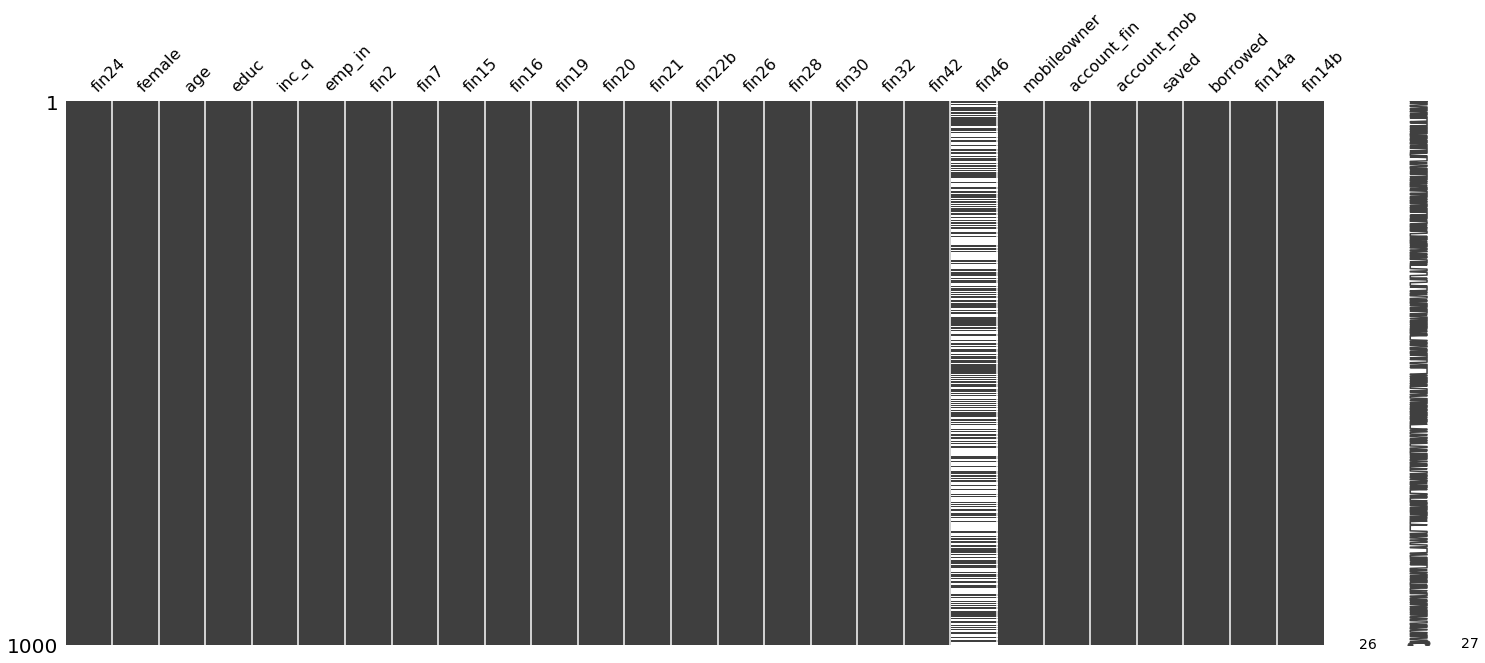

In [10]:
# Assess missingness graphically
miss.matrix(dat2)

Most of the fields are fully populated, but we will still have to convert encoded missing values (i.e., those corresponding to "don't know" or "refused to answer"). For fin46, the missingness is due to inapplicability of question and may thus be encoded as "no" or zero.

### (3) Data Cleaning

In [11]:
dat3 = dat2.copy()
dat3.head()

,fin24,female,age,educ,inc_q,emp_in,fin2,fin7,fin15,fin16,...,fin32,fin42,fin46,mobileowner,account_fin,account_mob,saved,borrowed,fin14a,fin14b
0,Not possible,Female,66,completed primary or less,Poorest 20%,out of workforce,no,no,no,no,...,no,no,yes,no,0,0,yes,0,no,no
1,Possible,Female,24,completed tertiary or more,Richest 20%,in workforce,yes,no,yes,yes,...,yes,no,NaN,yes,yes,0,yes,0,no,yes
2,Not possible,Female,88,completed primary or less,Fourth 20%,in workforce,yes,no,yes,yes,...,no,no,yes,no,yes,0,yes,0,no,no
3,Possible,Female,30,secondary,Richest 20%,in workforce,yes,no,yes,yes,...,no,no,yes,yes,yes,0,yes,yes,no,no
4,Possible,Female,33,completed tertiary or more,Richest 20%,in workforce,yes,no,no,yes,...,yes,yes,NaN,yes,yes,0,yes,0,no,no


`fin46` - Address missingness

In [12]:
# Convert missing data to 'no'
# This is reasonable because we could think of 'yes' as a switch that is
# activated if the respondent is self-employed.
dat3.fin46 = dat3.fin46.replace(np.nan,'no')

`"(ref)"` - Drop observations where respondent refused to answer

In [13]:
# Convert all '(ref)' (refused to answer) to NA and drop
dat3 = dat3.replace('(ref)',np.nan).dropna(axis=0,how='any')

In [14]:
dat3.shape

(994, 27)

`"(dk)"` - Convert observations where respondent does not know the answer

In [15]:
dat3[dat3.stack().str.contains("(dk)",regex=False).any(level=0)]

,fin24,female,age,educ,inc_q,emp_in,fin2,fin7,fin15,fin16,...,fin32,fin42,fin46,mobileowner,account_fin,account_mob,saved,borrowed,fin14a,fin14b
26,Not possible,Female,21,completed tertiary or more,Second 20%,in workforce,no,no,no,yes,...,no,no,no,yes,0,yes,yes,0,no,(dk)
164,(dk),Male,34,secondary,Poorest 20%,in workforce,no,no,no,no,...,no,yes,no,yes,0,0,0,0,no,no
231,(dk),Female,72,completed primary or less,Poorest 20%,in workforce,no,no,no,no,...,no,yes,no,yes,0,0,0,0,no,no
253,Not possible,Female,53,completed primary or less,Poorest 20%,out of workforce,no,no,no,yes,...,no,no,no,(dk),0,0,yes,yes,no,no
344,Not possible,Female,54,completed primary or less,Second 20%,in workforce,no,(dk),no,no,...,no,no,no,yes,yes,0,0,yes,no,no
404,Possible,Female,20,secondary,Second 20%,out of workforce,no,no,(dk),no,...,no,yes,no,yes,0,0,0,yes,no,no
455,Possible,Female,15,completed primary or less,Richest 20%,out of workforce,no,no,no,no,...,no,yes,no,yes,0,0,yes,yes,no,yes
493,(dk),Male,17,secondary,Second 20%,out of workforce,no,no,no,no,...,no,no,no,no,0,0,0,0,no,no
511,(dk),Male,15,completed primary or less,Fourth 20%,out of workforce,no,no,no,no,...,no,no,no,no,0,0,yes,0,no,no
517,Possible,Male,27,secondary,Middle 20%,in workforce,no,no,no,no,...,no,no,yes,yes,0,0,0,yes,no,no


Since there are just 17 rows, we can drop these for simplicity.

In [16]:
# Convert all '(dk)' (don't know) to NA and drop
dat3 = dat3.replace('(dk)',np.nan).dropna(axis=0,how='any')

In [17]:
dat3.shape

(977, 27)

`educ` - Convert to binary variables

In [18]:
# convert to binary variables
dat3 = pd.get_dummies(dat3, columns=["educ"])

`inc_q` - Convert to numeric

In [19]:
# convert ordinal 'inc_q' to numeric intervals
set(dat3.inc_q)

{'Fourth 20%', 'Middle 20%', 'Poorest 20%', 'Richest 20%', 'Second 20%'}

In [20]:
# create mapping for income quintiles
inc_levels = {'Fourth 20%':4, 'Middle 20%':3, 'Poorest 20%':1,
              'Richest 20%':5, 'Second 20%':2}

In [21]:
dat3.inc_q = [inc_levels[item] for item in dat3.inc_q]

`female` - Convert to dummy

In [22]:
# Convert to dummy
dat3.female = 1*(dat3.female=='Female')

`emp_in` - Convert to dummy

In [23]:
set(dat3.emp_in)

{'in workforce', 'out of workforce'}

In [24]:
# Convert to dummy
dat3.emp_in = 1*(dat3.emp_in=='in workforce')

`fin24` - Convert to dummy

In [25]:
set(dat3.fin24)

{'Not possible', 'Possible'}

In [26]:
# Convert to dummy
dat3.fin24 = 1*(dat3.fin24=='Possible')

`"yes"` and `"no"` - Convert to 1 and 0

In [27]:
# Convert all 'yes' to 1
dat3 = dat3.replace('yes',1)
# Convert all 'no' to 0
dat3 = dat3.replace('no',0)

In [28]:
dat3

,fin24,female,age,inc_q,emp_in,fin2,fin7,fin15,fin16,fin19,...,mobileowner,account_fin,account_mob,saved,borrowed,fin14a,fin14b,educ_completed primary or less,educ_completed tertiary or more,educ_secondary
0,0,1,66,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,1,1,24,5,1,1,0,1,1,0,...,1,1,0,1,0,0,1,0,1,0
2,0,1,88,4,1,1,0,1,1,0,...,0,1,0,1,0,0,0,1,0,0
3,1,1,30,5,1,1,0,1,1,0,...,1,1,0,1,1,0,0,0,0,1
4,1,1,33,5,1,1,0,0,1,0,...,1,1,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,0,27,1,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
996,0,0,68,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
997,1,1,18,4,1,0,0,0,1,0,...,1,0,0,1,0,0,1,0,0,1
998,1,0,20,4,1,0,0,0,0,0,...,1,0,0,1,1,0,0,0,0,1


`fin14a` and `fin14b` - Combine to generate new feature on the use of online transactions

In [29]:
# Combine fin14a and fin14b indicators in one feature
dat3['fin14'] = dat3.fin14a + dat3.fin14b

# Fix double count (change 2 to 1)
dat3.fin14 = dat3.fin14.replace(2,1)

# Drop fin14a and fin14b
dat3 = dat3.drop(['fin14a','fin14b'],axis=1)

Rename columns

In [30]:
dat3.columns

Index(['fin24', 'female', 'age', 'inc_q', 'emp_in', 'fin2', 'fin7', 'fin15',
       'fin16', 'fin19', 'fin20', 'fin21', 'fin22b', 'fin26', 'fin28', 'fin30',
       'fin32', 'fin42', 'fin46', 'mobileowner', 'account_fin', 'account_mob',
       'saved', 'borrowed', 'educ_completed primary or less',
       'educ_completed tertiary or more', 'educ_secondary', 'fin14'],
      dtype='object')

In [31]:
dat3.columns = ['emergency_fund','female','age','income_quintile','in_workforce','debit_card','credit_card','saved_business_12mos',
                'saved_retirement_12mos','loan_fin_realestate','borrowed_medical_12mos','borrowed_business_12mos',
                'borrowed_personal_12mos','remit_dom_sent_12mos','remit_dom_rcv_12mos','paid_bills_12mos',
                'payments_wage_12mos','payments_agri_12mos','payments_selfemp_12mos','mobileowner','account_fin',
                'account_mob','saved_12mos','borrowed_12mos','educ1_primaryorless',
                'educ3_tertiaryormore','educ2_secondary','online_txn']

Fix data types

In [32]:
dat3.dtypes

emergency_fund              int32
female                      int32
age                         int64
income_quintile             int64
in_workforce                int32
debit_card                  int64
credit_card                 int64
saved_business_12mos        int64
saved_retirement_12mos      int64
loan_fin_realestate         int64
borrowed_medical_12mos      int64
borrowed_business_12mos     int64
borrowed_personal_12mos     int64
remit_dom_sent_12mos        int64
remit_dom_rcv_12mos         int64
paid_bills_12mos            int64
payments_wage_12mos         int64
payments_agri_12mos         int64
payments_selfemp_12mos      int64
mobileowner                 int64
account_fin                object
account_mob                object
saved_12mos                object
borrowed_12mos             object
educ1_primaryorless         uint8
educ3_tertiaryormore        uint8
educ2_secondary             uint8
online_txn                  int64
dtype: object

In [33]:
# change all data types to numeric
cols = dat3.columns
dat3[cols] = dat3[cols].apply(pd.to_numeric)

In [34]:
dat3.dtypes

emergency_fund             int32
female                     int32
age                        int64
income_quintile            int64
in_workforce               int32
debit_card                 int64
credit_card                int64
saved_business_12mos       int64
saved_retirement_12mos     int64
loan_fin_realestate        int64
borrowed_medical_12mos     int64
borrowed_business_12mos    int64
borrowed_personal_12mos    int64
remit_dom_sent_12mos       int64
remit_dom_rcv_12mos        int64
paid_bills_12mos           int64
payments_wage_12mos        int64
payments_agri_12mos        int64
payments_selfemp_12mos     int64
mobileowner                int64
account_fin                int64
account_mob                int64
saved_12mos                int64
borrowed_12mos             int64
educ1_primaryorless        uint8
educ3_tertiaryormore       uint8
educ2_secondary            uint8
online_txn                 int64
dtype: object

#### (iii) Characterization of Processed Dataset

##### (a) Attribute types

In [35]:
dat3.head()

,emergency_fund,female,age,income_quintile,in_workforce,debit_card,credit_card,saved_business_12mos,saved_retirement_12mos,loan_fin_realestate,...,payments_selfemp_12mos,mobileowner,account_fin,account_mob,saved_12mos,borrowed_12mos,educ1_primaryorless,educ3_tertiaryormore,educ2_secondary,online_txn
0,0,1,66,1,0,0,0,0,0,0,...,1,0,0,0,1,0,1,0,0,0
1,1,1,24,5,1,1,0,1,1,0,...,0,1,1,0,1,0,0,1,0,1
2,0,1,88,4,1,1,0,1,1,0,...,1,0,1,0,1,0,1,0,0,0
3,1,1,30,5,1,1,0,1,1,0,...,1,1,1,0,1,1,0,0,1,0
4,1,1,33,5,1,1,0,0,1,0,...,0,1,1,0,1,0,0,1,0,0


All are binary except for: (1) age, which is numeric (from 15-95 per codebook); and (2) income_quintile (integers 1-5).

##### (b) Resolution

The resolution is at the individual-level.

##### (c) Dimensionality

In [36]:
dat3.shape

(977, 28)

##### (d) Missing values

In [37]:
dat3.isna().sum().sort_values()

emergency_fund             0
educ3_tertiaryormore       0
educ1_primaryorless        0
borrowed_12mos             0
saved_12mos                0
account_mob                0
account_fin                0
mobileowner                0
payments_selfemp_12mos     0
payments_agri_12mos        0
payments_wage_12mos        0
paid_bills_12mos           0
remit_dom_rcv_12mos        0
remit_dom_sent_12mos       0
borrowed_personal_12mos    0
borrowed_business_12mos    0
borrowed_medical_12mos     0
loan_fin_realestate        0
saved_retirement_12mos     0
saved_business_12mos       0
credit_card                0
debit_card                 0
in_workforce               0
income_quintile            0
age                        0
female                     0
educ2_secondary            0
online_txn                 0
dtype: int64

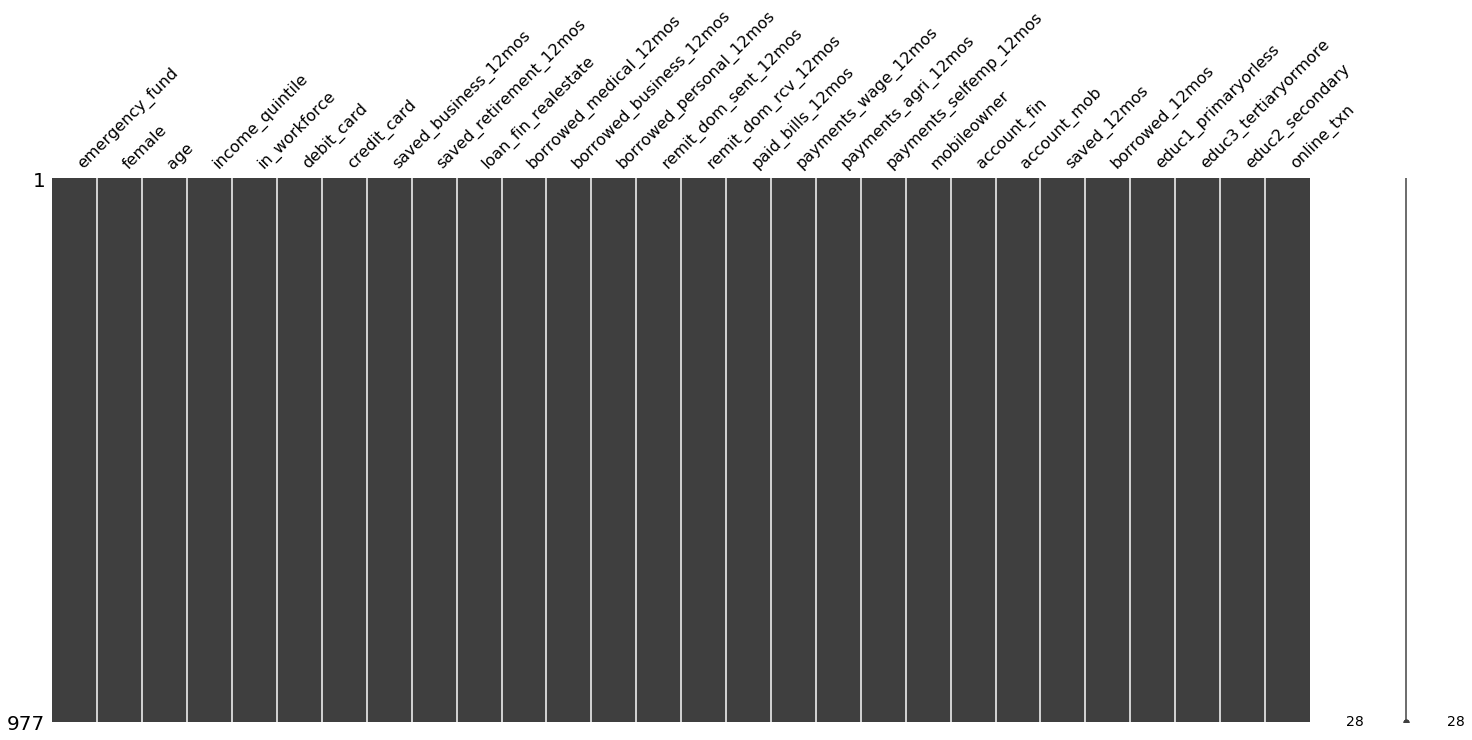

In [38]:
# Assess missingness graphically
miss.matrix(dat3)

There are no more missing values.

### (4) Numerical & Graphical Summaries

#### Outcome Variable

In [39]:
dat3.emergency_fund.value_counts()

0    496
1    481
Name: emergency_fund, dtype: int64

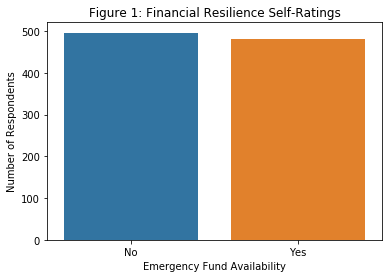

In [40]:
fig = plt.figure()
fig.add_axes()
ax = fig.add_subplot()
sns.countplot(x=dat3.emergency_fund)
plt.title("Figure 1: Financial Resilience Self-Ratings")
plt.ylabel("Number of Respondents")
plt.xlabel("Emergency Fund Availability")
ax.xaxis.set(ticklabels=["No","Yes"])
plt.savefig('Fig1.png')

There is no class imbalance in the outcome variable. It is a fairly balanced data set.

#### Numeric Variables

In [41]:
tab2 = dat3[["age","income_quintile"]].describe()
tab2 = tab2.transpose()[["min","mean","std","50%","max"]].round(1)
tab2.columns = ['Minimum','Mean','Std Deviation','Median','Maximum']
tab2.index = ['Age', 'Income Quintile']
tab2

,Minimum,Mean,Std Deviation,Median,Maximum
Age,15.0,40.6,17.5,37.0,95.0
Income Quintile,1.0,3.1,1.4,3.0,5.0


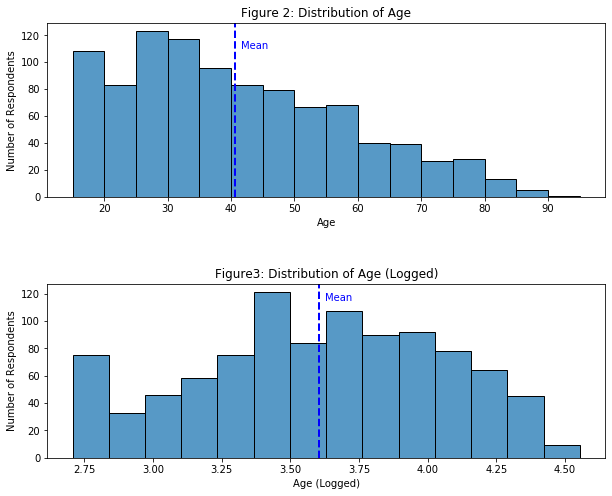

In [42]:
fig = plt.figure(figsize=(10,8))
fig.add_axes()
fig.subplots_adjust(hspace=.5)
ax1 = fig.add_subplot(211)
sns.histplot(dat3[["age"]],legend=False)
ax1.axvline(np.mean(dat3[["age"]])[0],linewidth=2,linestyle="--",color='b')
ax1.text(np.mean(dat3[["age"]])[0]+1, 110,"Mean",color='b')
plt.title('Figure 2: Distribution of Age')
plt.ylabel("Number of Respondents")
plt.xlabel("Age")

ax2 = fig.add_subplot(212)
sns.histplot(np.log(dat3["age"]))
plt.title('Figure3: Distribution of Age (Logged)')
ax2.axvline(np.mean(np.log(dat3[["age"]]))[0],linewidth=2,linestyle="--",color='b')
ax2.text(np.mean(np.log(dat3[["age"]]))[0]+.02, 115,"Mean",color='b')
plt.ylabel("Number of Respondents")
plt.xlabel("Age (Logged)")
plt.savefig('Fig23.png')

We could oversample on rare classes and undersample on dominant classes.

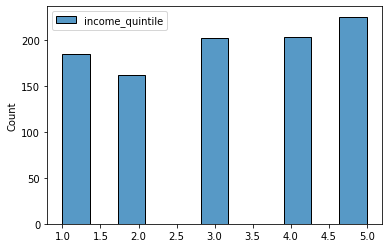

In [43]:
sns.histplot(dat3[["income_quintile"]])
plt.show()

We have a balanced dataset in terms of income quintile.

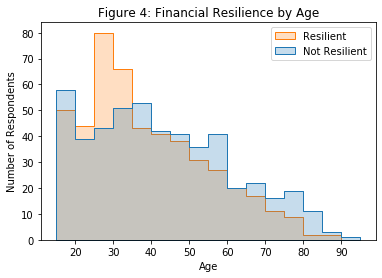

In [44]:
fig=plt.figure()
fig.add_axes()
sns.histplot(dat3,x="age",hue="emergency_fund",multiple="layer",element="step")
plt.title("Figure 4: Financial Resilience by Age")
plt.ylabel("Number of Respondents")
plt.xlabel("Age")
plt.legend(["Resilient","Not Resilient"])
plt.savefig('Fig4.png')

# https://seaborn.pydata.org/generated/seaborn.histplot.html

Roughly equally distributed across financial resilience except for respondents aged 20 to 40, which are predominantly resilient.

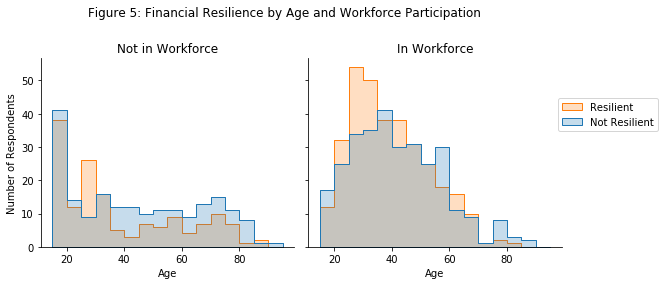

In [45]:
dp=sns.displot(
    dat3,x="age",col="in_workforce",multiple="layer",element="step",
    hue_order=[0,1], hue="emergency_fund" ,height=4,legend=False
)
for col_val,ax in dp.axes_dict.items():
    if col_val==0:
        ax.set_title("Not in Workforce")
    else:
        ax.set_title("In Workforce")
dp.set_axis_labels("Age","Number of Respondents")

dp.fig.subplots_adjust(top=.8)
dp.fig.suptitle("Figure 5: Financial Resilience by Age and Workforce Participation")
plt.legend(["Resilient","Not Resilient"],loc="center right",bbox_to_anchor=(1.4, .7))
plt.savefig('Fig5.png',bbox_inches="tight")

# https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn.displot

Those not in workforce are the younger ones (below 20). But note that those below 30 who are not in workforce are more financially resilient than their counterparts. However, in general, financial resilience is roughly equally distributed financial resilience across age groups.

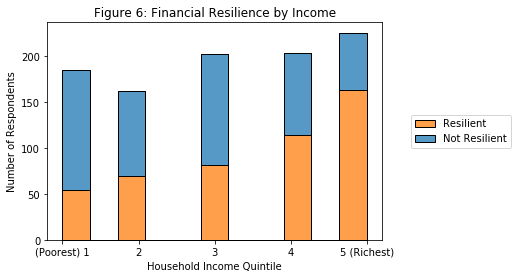

In [46]:
fig = plt.figure()
ax = fig.add_subplot()
plt.title("Figure 6: Financial Resilience by Income")
sns.histplot(dat3,x="income_quintile",hue="emergency_fund",multiple="stack",element="step")
plt.ylabel("Number of Respondents")
plt.xlabel("Household Income Quintile")
ax.xaxis.set(ticks=range(1,6),ticklabels=["(Poorest) 1","2",
                                          "3","4",
                                         "5 (Richest)"])
plt.legend(["Resilient","Not Resilient"],loc="center right",bbox_to_anchor=(1.4, .5))
plt.savefig('Fig6.png',bbox_inches="tight")

We observe reasonable values for both age and income quintiles.
* age - The standard deviation of 17.5 suggests that data is reasonably spread out and that the majority of respondents are of working age (i.e., aged 23 to 58 or range of 40.5 +/- 17.5). The comparably lower median of 37 (versus mean of 40.5) suggests that there may be older respondents in the outliers who are pulling the mean upwards.
* income quintile - Figures suggest uniform distribution (which means that our sample is representative across socioeconomic classes).

In [47]:
## Frequency Tabulation for Education Level
# Create temporary ordinal variable for education level
dat3["educ_temp"] = dat3.educ1_primaryorless*1 + dat3.educ3_tertiaryormore*3 + dat3.educ2_secondary*2

#setup dataframe
tab3_cols = ["Frequency","Relative Frequency (%)","Cumulative Frequency","Cumulative Relative Frequency (%)"]
tab3_index= ["Primary or less","Secondary", "Tertiary or more"]
tab3 = pd.DataFrame(index=tab3_index,columns=tab3_cols)

#initialize row and cumulative total
row = 0
cumulative = 0

#populate data frame
educ_counts = dat3["educ_temp"].value_counts().sort_index()
for i in educ_counts:
    #frequency
    tab3.iloc[row,0]=i
    #relative frequency
    tab3.iloc[row,1]=np.round(i/sum(educ_counts)*100,1)
    #cumulative frequency
    cumulative += i
    tab3.iloc[row,2]=cumulative
    #cumulative relative frequency
    tab3.iloc[row,3]=np.round(cumulative/sum(educ_counts)*100,1)
    #move to next row
    row+=1
    
tab3

,Frequency,Relative Frequency (%),Cumulative Frequency,Cumulative Relative Frequency (%)
Primary or less,285,29.2,285,29.2
Secondary,580,59.4,865,88.5
Tertiary or more,112,11.5,977,100


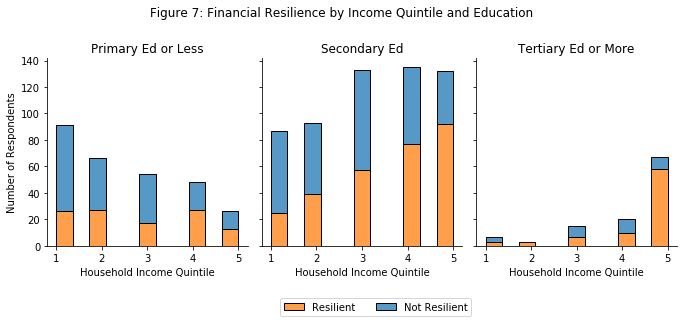

In [48]:
dp=sns.displot(
    dat3,x="income_quintile",hue="emergency_fund",multiple="stack",element="bars",
    col="educ_temp",height=4,aspect=.8,legend=False
)
for col_val,ax in dp.axes_dict.items():
    if col_val==1:
        ax.set_title("Primary Ed or Less")
    if col_val==2:
        ax.set_title("Secondary Ed")
    if col_val==3:
        ax.set_title("Tertiary Ed or More")
dp.set_axis_labels("Household Income Quintile","Number of Respondents")

dp.fig.subplots_adjust(top=.8)
dp.fig.suptitle("Figure 7: Financial Resilience by Income Quintile and Education")
plt.legend(["Resilient","Not Resilient"],bbox_to_anchor=(0, -.25), ncol=2)
plt.savefig('Fig7.png',bbox_inches="tight")

#### Binary Variables

In [49]:
## Financial Resilience by Sex
# Create temporary categorical variable
dat3["sex_temp"] = np.where(dat3.female==1,"female","male")

# Setup dataframe
tab4_cols = ["Not Financially Resilient",
             "Financially Resilient",
             "Total",
             "Financial Resilience (%)"]
tab4_index= ["Female","Male"]
tab4 = pd.DataFrame(index=tab4_index,columns=tab4_cols)

#populate data frame
sex_crosstab = pd.crosstab(dat3.sex_temp,dat3.emergency_fund)
#encode crosstab to first 2 columns
for i in [0,1]:
    row=0
    for j in sex_crosstab[i]:
        tab4.iloc[row,i]=j
        row+=1
#compute last 2 columns
tab4["Total"]=tab4["Not Financially Resilient"]+tab4["Financially Resilient"]
tab4["Financial Resilience (%)"]=tab4["Financially Resilient"]/tab4["Total"]*100

tab4.round(1)

,Not Financially Resilient,Financially Resilient,Total,Financial Resilience (%)
Female,297,252,549,45.9016
Male,199,229,428,53.5047


##### Frequency tables for each categorical feature

In [50]:
dat3_cat = dat3.filter(['emergency_fund','in_workforce','debit_card','credit_card','saved_business_12mos','saved_retirement_12mos','loan_fin_realestate','borrowed_medical_12mos','borrowed_business_12mos','borrowed_personal_12mos','remit_dom_sent_12mos','remit_dom_rcv_12mos','paid_bills_12mos','payments_wage_12mos','payments_agri_12mos','payments_selfemp_12mos','mobileowner','account_fin','account_mob','saved_12mos','borrowed_12mos','female','online_txn'])
#'educ1_primaryorless','educ3_tertiaryormore','educ2_secondary'

In [51]:
freqtab = pd.DataFrame({'Yes': dat3_cat.sum(),
              'No': dat3_cat.count()-dat3_cat.sum(),
              'Yes_Pct': round(dat3_cat.sum()/dat3_cat.count()*100,1)}).reset_index().sort_values(by="Yes",ascending=False)
freqtab.head()

,index,Yes,No,Yes_Pct
16,mobileowner,740,237,75.7
1,in_workforce,630,347,64.5
19,saved_12mos,583,394,59.7
20,borrowed_12mos,579,398,59.3
12,paid_bills_12mos,552,425,56.5


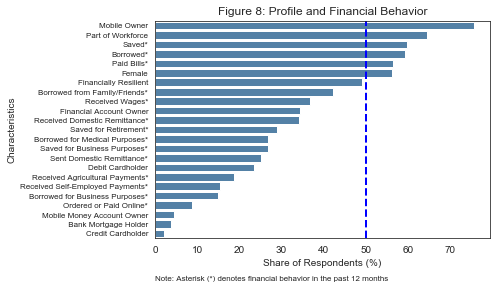

In [52]:
sns.set_style("white")
fig = plt.figure()#figsize=(8,8))
ax = fig.add_subplot()
plt.title("Figure 8: Profile and Financial Behavior")
sns.barplot(y="index",x="Yes_Pct",data=freqtab,color='steelblue')
ax.set_yticklabels(['Mobile Owner','Part of Workforce','Saved*','Borrowed*','Paid Bills*','Female','Financially Resilient','Borrowed from Family/Friends*','Received Wages*','Financial Account Owner','Received Domestic Remittance*','Saved for Retirement*','Borrowed for Medical Purposes*','Saved for Business Purposes*','Sent Domestic Remittance*','Debit Cardholder','Received Agricultural Payments*','Received Self-Employed Payments*','Borrowed for Business Purposes*','Ordered or Paid Online*','Mobile Money Account Owner',' Bank Mortgage Holder','Credit Cardholder'],
                   size=8)
#ax.yaxis.set(ticklabels=['Mobile Owner','Part of Workforce','Saved*','Borrowed*','Paid Bills*','Female','Financially Resilient','Borrowed from Family/Friends*','Received Wages*','Financial Account Owner','Received Domestic Remittance*','Saved for Retirement*','Borrowed for Medical Purposes*','Saved for Business Purposes*','Sent Domestic Remittance*','Debit Cardholder','Received Agricultural Payments*','Received Self-Employed Payments*','Borrowed for Business Purposes*','Ordered or Paid Online*','Mobile Money Account Owner',' Bank Mortgage Holder','Credit Cardholder'],
#            size=2)
ax.axvline(50,linewidth=2,linestyle="--",color='b')
ax.text(0, 27,"Note: Asterisk (*) denotes financial behavior in the past 12 months",
        size=8)
plt.ylabel("Characteristics")
plt.xlabel("Share of Respondents (%)")
plt.savefig('Fig8.png',bbox_inches = "tight",dpi=300)

##### Correlation Heatmap

In [53]:
dat3_cat_smc = dat3_cat.reset_index(drop=True)

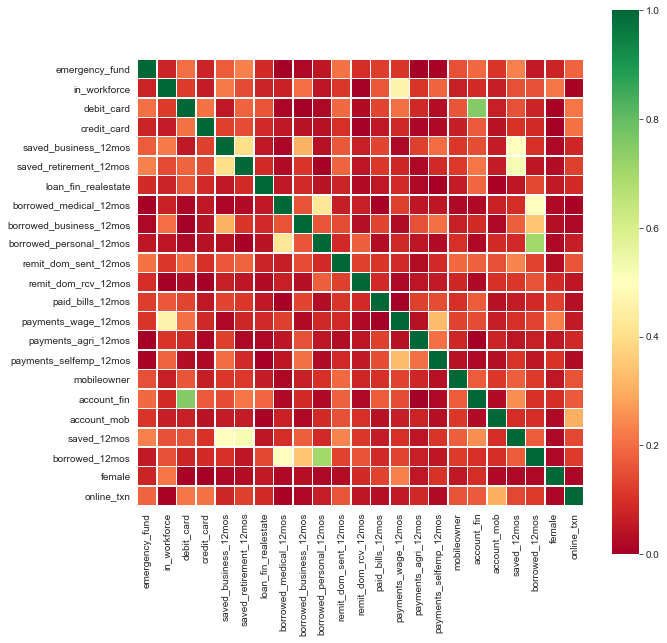

In [54]:
plt.figure(figsize = (10,10))
sns.heatmap(abs(dat3_cat_smc.corr()),cmap="RdYlGn",vmin=0,vmax=1,linewidths=.5,annot=False,square=True)
plt.show()

Correlation (nor VIF) may not be appropriate for binary variables. We should use simple matching coefficient.

##### Simple Matching Coefficient (SMC) Heatmap

In [55]:
def smc_list(y1,y2):
    """
    This function calculates the simple matching coefficient between 2 vectors.
    
    Argument/Input:
        y1, y2 (list): vectors to be compared
                
    Returns:
        simple matching coefficient

    """    
    n = 0
    match = 0
    print(len(y1),len(y2))
    for i in range(len(y1)):
        if y1[i] == y2[i]:
            match += 1
        n+=1
    
    smc = match/n
    return(smc)

In [56]:
def smc_df(dat):
    """
    This function calculates the simple matching coefficient between columns in a dataframe.
    
    Argument/Input:
        dataframe
                
    Returns:
        dataframe of simple matching coefficients

    """    
    smc_df = pd.DataFrame(index=dat.columns,columns=dat.columns)
    for col1 in dat:
        for col2 in dat:
            n = 0
            match = 0
            for i in range(len(dat)):
                if dat[col1][i] == dat[col2][i]:
                    match += 1
                n+=1
            smc = match/n
            smc_df.loc[col1,col2]=smc
    return(smc_df)

In [57]:
smc_matrix=smc_df(dat3_cat_smc)

In [58]:
smc_matrix

,emergency_fund,in_workforce,debit_card,credit_card,saved_business_12mos,saved_retirement_12mos,loan_fin_realestate,borrowed_medical_12mos,borrowed_business_12mos,borrowed_personal_12mos,...,payments_wage_12mos,payments_agri_12mos,payments_selfemp_12mos,mobileowner,account_fin,account_mob,saved_12mos,borrowed_12mos,female,online_txn
emergency_fund,1,0.534289,0.590583,0.517912,0.580348,0.609007,0.524053,0.502559,0.498465,0.525077,...,0.554759,0.505629,0.5087,0.562948,0.594678,0.529171,0.613101,0.527124,0.461617,0.558854
in_workforce,0.534289,1,0.470829,0.369498,0.5261,0.501535,0.379734,0.462641,0.466735,0.497441,...,0.674514,0.449335,0.464688,0.602866,0.495394,0.380757,0.599795,0.599795,0.415558,0.383828
debit_card,0.590583,0.470829,1,0.779939,0.643808,0.682702,0.77175,0.619243,0.686796,0.549642,...,0.653019,0.63869,0.674514,0.421699,0.885363,0.75435,0.512794,0.482088,0.463664,0.769703
credit_card,0.517912,0.369498,0.779939,1,0.738997,0.720573,0.948823,0.716479,0.841351,0.571136,...,0.637666,0.799386,0.829069,0.261003,0.67349,0.939611,0.421699,0.423746,0.440123,0.911975
saved_business_12mos,0.580348,0.5261,0.643808,0.738997,1,0.758444,0.724667,0.613101,0.760491,0.553736,...,0.569089,0.689867,0.723644,0.421699,0.635619,0.723644,0.67042,0.500512,0.463664,0.712385
saved_retirement_12mos,0.609007,0.501535,0.682702,0.720573,0.758444,1,0.710338,0.588536,0.682702,0.531218,...,0.58956,0.63869,0.674514,0.436029,0.658137,0.703173,0.692938,0.482088,0.461617,0.706244
loan_fin_realestate,0.524053,0.379734,0.77175,0.948823,0.724667,0.710338,1,0.724667,0.837257,0.581372,...,0.637666,0.793245,0.82088,0.271238,0.679632,0.923234,0.419652,0.440123,0.431934,0.891505
borrowed_medical_12mos,0.502559,0.462641,0.619243,0.716479,0.613101,0.588536,0.724667,1,0.713408,0.721597,...,0.616172,0.663255,0.645855,0.386899,0.582395,0.725691,0.496418,0.674514,0.461617,0.689867
borrowed_business_12mos,0.498465,0.466735,0.686796,0.841351,0.760491,0.682702,0.837257,0.713408,1,0.613101,...,0.601842,0.763562,0.795292,0.339816,0.64176,0.823951,0.494371,0.555783,0.445241,0.78608
borrowed_personal_12mos,0.525077,0.497441,0.549642,0.571136,0.553736,0.531218,0.581372,0.721597,0.613101,1,...,0.560901,0.567042,0.563971,0.501535,0.535312,0.590583,0.527124,0.828045,0.482088,0.583419


In [59]:
# change all data types to numeric
cols = smc_matrix.columns
smc_matrix[cols] = smc_matrix[cols].apply(pd.to_numeric)

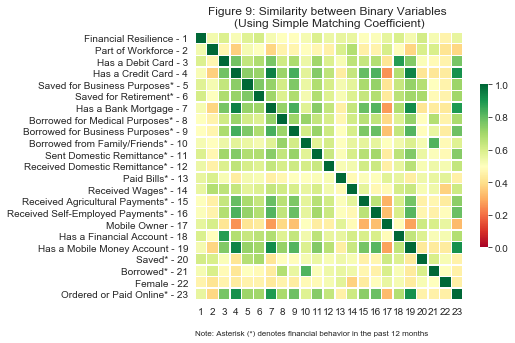

In [60]:
# Plot heatmap showing SMC values among the variables
fig=plt.figure(figsize = (6,6)) 
ax = fig.add_subplot()
plt.title("Figure 9: Similarity between Binary Variables \n(Using Simple Matching Coefficient)")
sns.heatmap(smc_matrix,cmap="RdYlGn",vmin=0,vmax=1,linewidths=.5,square=True,
            cbar_kws={"shrink": .5},
           xticklabels=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23'],
           yticklabels=['Financial Resilience - 1','Part of Workforce - 2','Has a Debit Card - 3','Has a Credit Card - 4','Saved for Business Purposes* - 5','Saved for Retirement* - 6','Has a Bank Mortgage - 7','Borrowed for Medical Purposes* - 8','Borrowed for Business Purposes* - 9','Borrowed from Family/Friends* - 10','Sent Domestic Remittance* - 11','Received Domestic Remittance* - 12','Paid Bills* - 13','Received Wages* - 14','Received Agricultural Payments* - 15','Received Self-Employed Payments* - 16','Mobile Owner - 17','Has a Financial Account - 18','Has a Mobile Money Account - 19','Saved* - 20','Borrowed* - 21','Female - 22','Ordered or Paid Online* - 23'])
#ax.set_xticklabels(['Financial Resilience','Part of Workforce','Has a Debit Card','Has a Credit Card','Saved for Business Purposes*','Saved for Retirement*','Has a Bank Mortgage','Borrowed for Medical Purposes*','Borrowed for Business Purposes*','Borrowed from Family/Friends*','Sent Domestic Remittance*','Received Domestic Remittance*','Paid Bills*','Received Wages*','Received Agricultural Payments*','Received Self-Employed Payments*','Mobile Owner','Has a Financial Account','Has a Mobile Money Account','Saved*','Borrowed*','Female','Ordered or Paid Online*'])
ax.text(0, 26,"Note: Asterisk (*) denotes financial behavior in the past 12 months",
       size=8)
plt.xticks(rotation=0)
plt.savefig('Fig9.png',bbox_inches = "tight",dpi=300)

Financial resilience is not connected to any particular indicator.

Large SMCs (at least .9) were found for:
* credit_card & loan_fin_realestate
* credit_card & account_mob
* credit_card & online_txn
*  loan_fin_realestate & account_mob
*  account_mob & online_txn

These are the bottom 4 indicators. Srong correlations imply that respondents belonging to this class are few but homogenous.

### (5) Modeling

#### (a) Decision Tree

##### (i) Preprocessing

In [61]:
dat3.shape

(977, 30)

In [62]:
dat3.columns

Index(['emergency_fund', 'female', 'age', 'income_quintile', 'in_workforce',
       'debit_card', 'credit_card', 'saved_business_12mos',
       'saved_retirement_12mos', 'loan_fin_realestate',
       'borrowed_medical_12mos', 'borrowed_business_12mos',
       'borrowed_personal_12mos', 'remit_dom_sent_12mos',
       'remit_dom_rcv_12mos', 'paid_bills_12mos', 'payments_wage_12mos',
       'payments_agri_12mos', 'payments_selfemp_12mos', 'mobileowner',
       'account_fin', 'account_mob', 'saved_12mos', 'borrowed_12mos',
       'educ1_primaryorless', 'educ3_tertiaryormore', 'educ2_secondary',
       'online_txn', 'educ_temp', 'sex_temp'],
      dtype='object')

In [63]:
dat4 = dat3.drop(columns=['educ_temp', 'sex_temp'])

In [64]:
dat4.shape

(977, 28)

In [65]:
# examine the baseline resilience rate
dat4.emergency_fund.mean()

0.4923234390992835

In [66]:
1-dat4.emergency_fund.mean()

0.5076765609007166

##### (ii) Model Building

In [67]:
# split into training and test sets
Y = dat4['emergency_fund']
X = dat4.drop('emergency_fund', axis=1)

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=1)

In [68]:
Xtest.shape

(294, 27)

In [69]:
Xtrain.shape

(683, 27)

In [70]:
# Fit model
tree = DecisionTreeClassifier(random_state=1)
tree

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

##### Hyper-parameter Tuning: Max. Tree Depth

In [71]:
# Validation curve
depth_range = np.arange(1,11)
train_scores, test_scores = validation_curve(tree,
                                             X, Y,
                                             param_name='max_depth',
                                             param_range=depth_range,
                                             cv=5)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

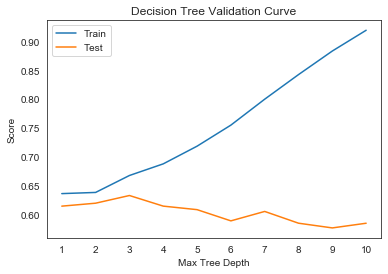

In [72]:
fig1 = plt.figure()
plt.plot(depth_range, train_mean, label='Train')
plt.plot(depth_range, test_mean, label='Test')
plt.xlabel('Max Tree Depth')
plt.ylabel('Score')
plt.title('Decision Tree Validation Curve')
plt.legend()
plt.xticks(depth_range)
plt.show()

In [73]:
pd.DataFrame({'tree_depth':depth_range,
              'train_mean':train_mean.round(4),
              'test_mean':test_mean.round(4),
             'difference':(train_mean-test_mean).round(4)}).sort_values(by="difference",ascending=True)

,tree_depth,train_mean,test_mean,difference
1,2,0.6379,0.6192,0.0187
0,1,0.6359,0.6141,0.0218
2,3,0.6674,0.6326,0.0348
3,4,0.6876,0.6142,0.0734
4,5,0.7183,0.6080,0.1102
5,6,0.7549,0.5885,0.1663
6,7,0.7999,0.6049,0.1950
7,8,0.8426,0.5845,0.2581
8,9,0.8836,0.5763,0.3073
9,10,0.9196,0.5844,0.3352


Based on the validation curve, I will choose a value of 3 for maximum tree depth. At this value, the test mean is at its highest. There is also a tolerable difference between training and test mean scores.

In [74]:
# Set max tree depth to 3
max_depth = 3
tree1 = DecisionTreeClassifier(max_depth=max_depth,
                              random_state=1)

In [75]:
# Fit model
tree1.fit(Xtrain,Ytrain)
tree1_acc = tree1.score(Xtest, Ytest)
tree1_acc

0.6462585034013606

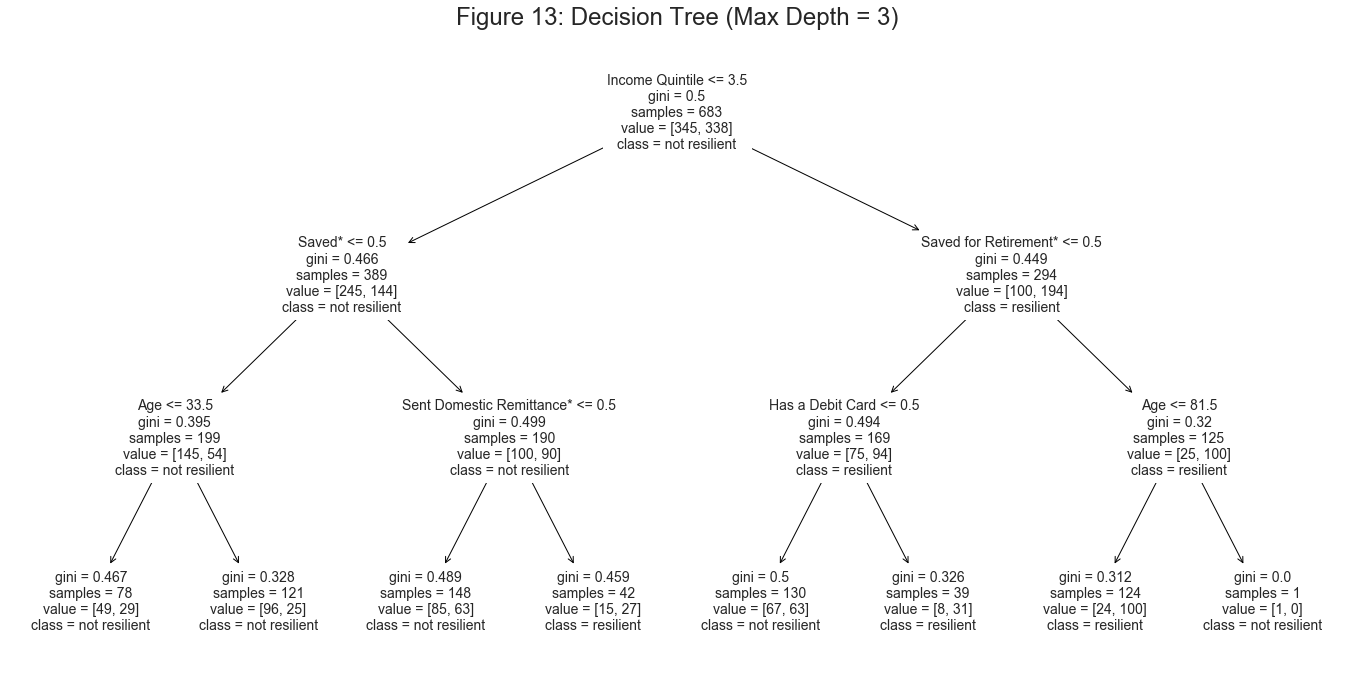

In [76]:
# visualize tree
yticklabels=['Female','Age','Income Quintile','Part of Workforce','Has a Debit Card','Has a Credit Card','Saved for Business Purposes*','Saved for Retirement*','Has a Bank Mortgage','Borrowed for Medical Purposes*','Borrowed for Business Purposes*','Borrowed from Family/Friends*','Sent Domestic Remittance*','Received Domestic Remittance*','Paid Bills*','Received Wages*','Received Agricultural Payments*','Received Self-Employed Payments*','Mobile Owner','Has a Financial Account','Has a Mobile Money Account','Saved*','Borrowed*','Education - Primary','Education - Tertiary','Education - Secondary','Ordered or Paid Online*']
plt.figure(figsize=(24, 12))
out = plot_tree(tree1, feature_names = yticklabels, 
          class_names = list(["not resilient","resilient"]),
               fontsize=14)
from sklearn import tree
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(1)
plt.title("Figure 13: Decision Tree (Max Depth = 3)",fontsize=24)
plt.savefig('Fig13.png',bbox_inches="tight")

In [77]:
# calculate node importance
tree1_impt = pd.DataFrame({'Feature': Xtest.columns,
              'Importance': tree1.feature_importances_})

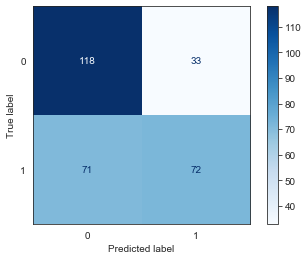

In [78]:
## Confusion Matrix
plot_confusion_matrix(tree1, Xtest, Ytest,
                      values_format=',d',
                     cmap = plt.cm.Blues)

In [79]:
tree1_cm = confusion_matrix(tree1.predict(Xtest),Ytest)
tree1_cm

array([[118,  71],
       [ 33,  72]], dtype=int64)

False positives (at 33) are less prevalent than false negatives (at 71).

In [80]:
sizes = np.arange(10, 780, 25)
train_sizes, train_scores, test_scores = learning_curve(tree1, 
                                                        X, Y, cv=5, train_sizes=sizes)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

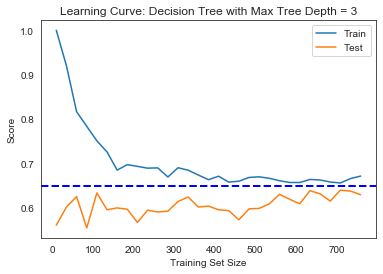

In [81]:
#### LEARNING CURVE
fig2 = plt.figure()
plt.plot(sizes, train_mean, label='Train')
plt.plot(sizes, test_mean, label='Test')
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.title('Learning Curve: Decision Tree with Max Tree Depth = 3')
plt.axhline(0.65,linewidth=2,linestyle="--",color='b')
plt.legend()
plt.show()
#fig2.savefig('learning_curve.png')

In [82]:
Xtest.shape

(294, 27)

##### Hyper-parameter Tuning: Min. Samples per Leaf

In [83]:
### HYPERPARAMETER TUNING -- MIN SAMPLES LEAF
# Validation curve
tree2 = DecisionTreeClassifier(random_state=1)
min_samples_leaf_range = np.arange(1,100)
train_scores, test_scores = validation_curve(tree2,
                                             X, Y,
                                             param_name='min_samples_leaf',
                                             param_range=min_samples_leaf_range,
                                             cv=5)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

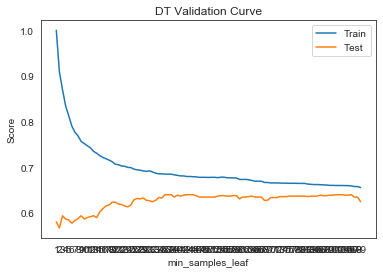

In [84]:
fig1 = plt.figure()
plt.plot(min_samples_leaf_range, train_mean, label='Train')
plt.plot(min_samples_leaf_range, test_mean, label='Test')
plt.xticks(min_samples_leaf_range)
plt.xlabel('min_samples_leaf')
plt.ylabel('Score')
plt.title('DT Validation Curve')
plt.legend()
plt.show()

In [85]:
pd.DataFrame({'min_samples_leaf':min_samples_leaf_range,
              'train_mean':train_mean.round(4),
              'test_mean':test_mean.round(4),
             'difference':(train_mean-test_mean).round(4)}).sort_values(by="difference",ascending=True).head(10)

,min_samples_leaf,train_mean,test_mean,difference
95,96,0.6589,0.6397,0.0192
92,93,0.6599,0.6397,0.0202
91,92,0.6599,0.6397,0.0202
90,91,0.6599,0.6397,0.0202
94,95,0.6597,0.6387,0.0210
93,94,0.6597,0.6387,0.0210
88,89,0.6602,0.6387,0.0215
89,90,0.6602,0.6387,0.0215
85,86,0.6617,0.6387,0.0230
97,98,0.6576,0.6346,0.0230


In [86]:
pd.DataFrame({'min_samples_leaf':min_samples_leaf_range,
              'train_mean':train_mean.round(4),
              'test_mean':test_mean.round(4),
             'difference':(train_mean-test_mean).round(4)}).sort_values(by="test_mean",ascending=False).head(10)

,min_samples_leaf,train_mean,test_mean,difference
36,37,0.6848,0.6397,0.0450
92,93,0.6599,0.6397,0.0202
43,44,0.6796,0.6397,0.0399
42,43,0.6796,0.6397,0.0399
91,92,0.6599,0.6397,0.0202
90,91,0.6599,0.6397,0.0202
95,96,0.6589,0.6397,0.0192
35,36,0.6848,0.6397,0.0450
37,38,0.6848,0.6397,0.0450
44,45,0.6791,0.6397,0.0394


In [87]:
# Set min_samples_leaf
min_samples_leaf = 93
tree2 = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf,
                              random_state=1)

In [88]:
# Fit model
tree2.fit(Xtrain,Ytrain)
tree2_acc = tree2.score(Xtest, Ytest)
tree2_acc

0.6224489795918368

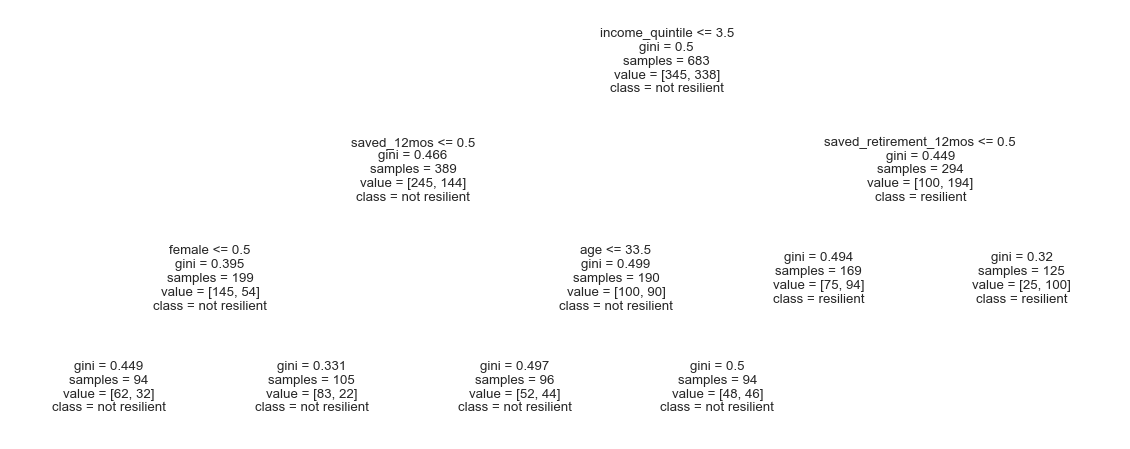

In [89]:
# visualize tree
plt.figure(figsize=(20, 8))
plot_tree(tree2, feature_names = Xtrain.columns, 
          class_names = list(["not resilient","resilient"]))
plt.show()

In [90]:
# calculate node importance
tree2_impt = pd.DataFrame({'Feature': Xtest.columns,
              'Importance': tree2.feature_importances_})
tree2_impt

,Feature,Importance
0,female,0.036638
1,age,0.001971
2,income_quintile,0.605762
3,in_workforce,0.000000
4,debit_card,0.000000
5,credit_card,0.000000
6,saved_business_12mos,0.000000
7,saved_retirement_12mos,0.184097
8,loan_fin_realestate,0.000000
9,borrowed_medical_12mos,0.000000


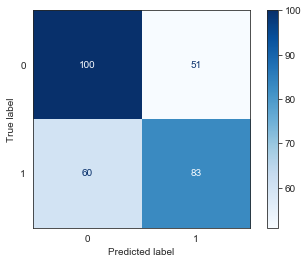

In [91]:
## Confusion Matrix
plot_confusion_matrix(tree2, Xtest, Ytest,
                      values_format=',d',
                     cmap = plt.cm.Blues)

False positives (at 51) are less prevalent than false negatives (at 60).

In [92]:
tree2_cm = confusion_matrix(tree2.predict(Xtest),Ytest)
tree2_cm

array([[100,  60],
       [ 51,  83]], dtype=int64)

In [93]:
sizes = np.arange(10, 780, 25)
train_sizes, train_scores, test_scores = learning_curve(tree2, 
                                                        X, Y, cv=5, train_sizes=sizes)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

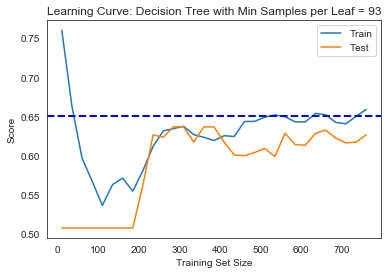

In [94]:
#### LEARNING CURVE
fig2 = plt.figure()
plt.plot(sizes, train_mean, label='Train')
plt.plot(sizes, test_mean, label='Test')
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.title('Learning Curve: Decision Tree with Min Samples per Leaf = 93')
plt.axhline(0.65,linewidth=2,linestyle="--",color='b')
plt.legend()
plt.show()
#fig2.savefig('learning_curve.png')

# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

##### Hyper-parameter Tuning: Cost Complexity Pruning
https://towardsdatascience.com/decision-tree-classifier-and-cost-computation-pruning-using-python-b93a0985ea77

In [95]:
tree = DecisionTreeClassifier(random_state=1)
ccp_alpha_range = np.arange(0,.015,.001)
train_scores, test_scores = validation_curve(tree,
                                             X, Y,
                                             param_name='ccp_alpha',
                                             param_range=ccp_alpha_range,
                                             cv=5)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

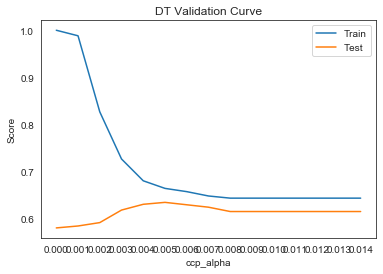

In [96]:
fig1 = plt.figure()
plt.plot(ccp_alpha_range, train_mean, label='Train')
plt.plot(ccp_alpha_range, test_mean, label='Test')
plt.xticks(ccp_alpha_range)
plt.xlabel('ccp_alpha')
plt.ylabel('Score')
plt.title('DT Validation Curve')
plt.legend()
plt.show()

In [97]:
pd.DataFrame({'ccp_alpha':ccp_alpha_range,
              'train_mean':train_mean.round(4),
              'test_mean':test_mean.round(4),
             'difference':(train_mean-test_mean).round(4)}).sort_values(by="difference",ascending=True).head(10)

,ccp_alpha,train_mean,test_mean,difference
7,0.007,0.6482,0.6244,0.0238
6,0.006,0.6574,0.6295,0.0279
8,0.008,0.6436,0.6152,0.0284
9,0.009,0.6436,0.6152,0.0284
10,0.010,0.6436,0.6152,0.0284
11,0.011,0.6436,0.6152,0.0284
12,0.012,0.6436,0.6152,0.0284
13,0.013,0.6436,0.6152,0.0284
14,0.014,0.6436,0.6152,0.0284
5,0.005,0.6643,0.6346,0.0297


In [98]:
pd.DataFrame({'ccp_alpha':ccp_alpha_range,
              'train_mean':train_mean.round(4),
              'test_mean':test_mean.round(4),
             'difference':(train_mean-test_mean).round(4)}).sort_values(by="test_mean",ascending=False).head(10)

,ccp_alpha,train_mean,test_mean,difference
5,0.005,0.6643,0.6346,0.0297
4,0.004,0.6804,0.6305,0.0499
6,0.006,0.6574,0.6295,0.0279
7,0.007,0.6482,0.6244,0.0238
3,0.003,0.7267,0.6182,0.1085
8,0.008,0.6436,0.6152,0.0284
9,0.009,0.6436,0.6152,0.0284
10,0.010,0.6436,0.6152,0.0284
11,0.011,0.6436,0.6152,0.0284
12,0.012,0.6436,0.6152,0.0284


In [99]:
# Set ccp_alpha
ccp_alpha = 0.005
tree3 = DecisionTreeClassifier(ccp_alpha=ccp_alpha,
                              random_state=1)

In [100]:
# Fit model
tree3.fit(Xtrain,Ytrain)
tree3_acc= tree3.score(Xtest, Ytest)
tree3_acc

0.6428571428571429

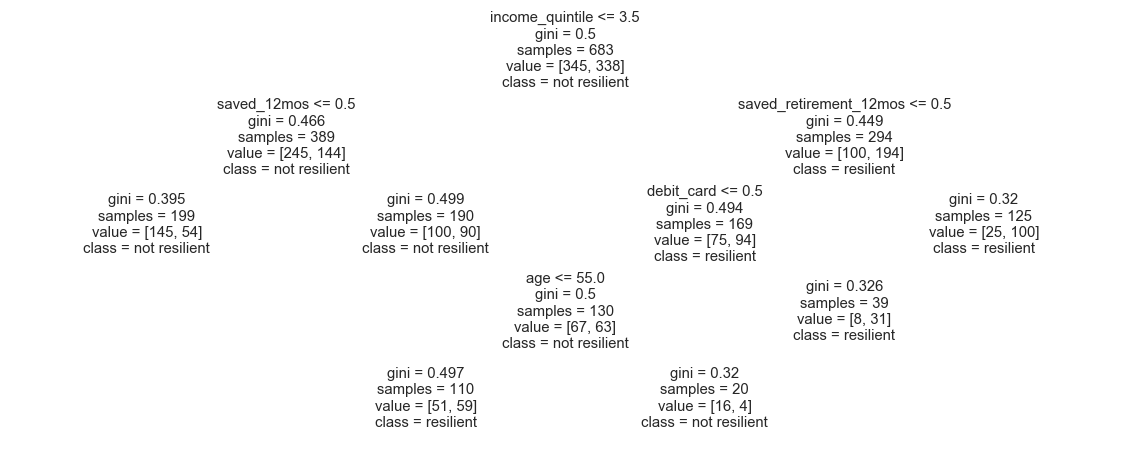

In [101]:
# visualize tree
plt.figure(figsize=(20, 8))
plot_tree(tree3, feature_names = Xtrain.columns, 
          class_names = list(["not resilient","resilient"]))
plt.show()

In [102]:
# calculate node importance
tree3_impt = pd.DataFrame({'Feature': Xtest.columns,
              'Importance': tree3.feature_importances_})
tree3_impt

,Feature,Importance
0,female,0.000000
1,age,0.070644
2,income_quintile,0.518444
3,in_workforce,0.000000
4,debit_card,0.106546
5,credit_card,0.000000
6,saved_business_12mos,0.000000
7,saved_retirement_12mos,0.157560
8,loan_fin_realestate,0.000000
9,borrowed_medical_12mos,0.000000


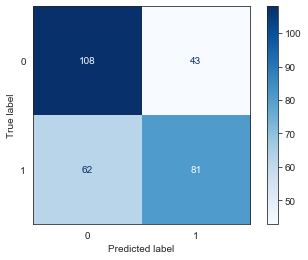

In [103]:
## Confusion Matrix
plot_confusion_matrix(tree3, Xtest, Ytest,
                      values_format=',d',
                     cmap = plt.cm.Blues)

False positives (at 43) are less prevalent than false negatives (at 62).

In [104]:
tree3_cm = confusion_matrix(tree3.predict(Xtest),Ytest)
tree3_cm

array([[108,  62],
       [ 43,  81]], dtype=int64)

In [105]:
sizes = np.arange(10, 780, 25)
train_sizes, train_scores, test_scores = learning_curve(tree3, 
                                                        X, Y, cv=5, train_sizes=sizes)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

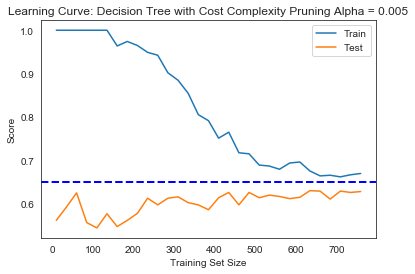

In [106]:
#### LEARNING CURVE
fig2 = plt.figure()
plt.plot(sizes, train_mean, label='Train')
plt.plot(sizes, test_mean, label='Test')
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.title('Learning Curve: Decision Tree with Cost Complexity Pruning Alpha = 0.005')
plt.axhline(0.65,linewidth=2,linestyle="--",color='b')
plt.legend()
plt.show()
#fig2.savefig('learning_curve.png')

##### Hyper-parameter Tuning: Combination of All Previous

In [107]:
tree4 = DecisionTreeClassifier(ccp_alpha=ccp_alpha,
                                       max_depth=max_depth,
                                       min_samples_leaf=min_samples_leaf,
                                       random_state=1)

In [108]:
# Fit model
tree4.fit(Xtrain,Ytrain)
tree4_acc = tree4.score(Xtest, Ytest)
tree4_acc

0.6224489795918368

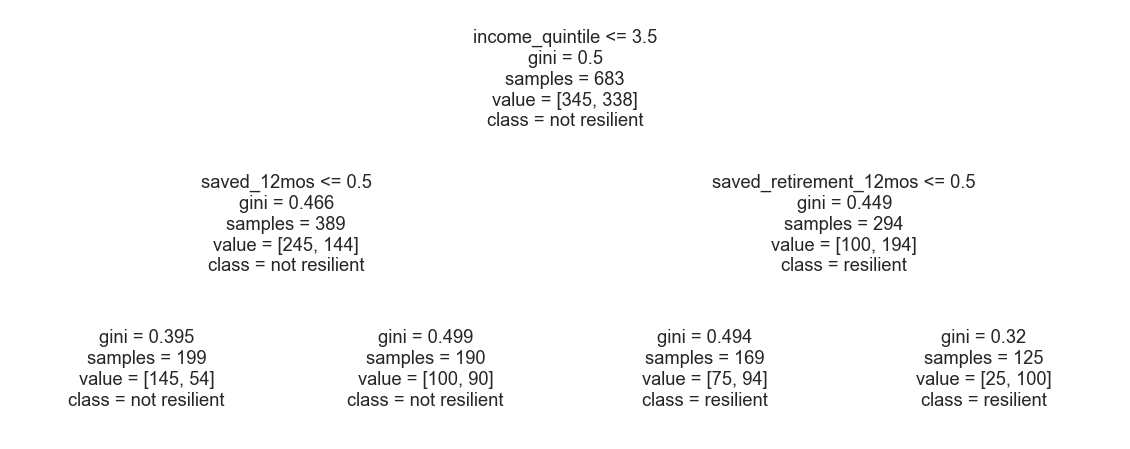

In [109]:
# visualize tree
plt.figure(figsize=(20, 8))
plot_tree(tree4, feature_names = Xtrain.columns, 
          class_names = list(["not resilient","resilient"]))
plt.show()

In [110]:
# calculate node importance
tree4_impt = pd.DataFrame({'Feature': Xtest.columns,
              'Importance': tree4.feature_importances_})

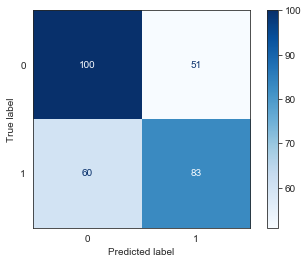

In [111]:
## Confusion Matrix
plot_confusion_matrix(tree4, Xtest, Ytest,
                      values_format=',d',
                     cmap = plt.cm.Blues)

False positives (at 51) are less prevalent than false negatives (at 60).

In [112]:
tree4_cm = confusion_matrix(tree4.predict(Xtest),Ytest)
tree4_cm 

array([[100,  60],
       [ 51,  83]], dtype=int64)

In [113]:
sizes = np.arange(10, 780, 25)
train_sizes, train_scores, test_scores = learning_curve(tree4, 
                                                        X, Y, cv=5, train_sizes=sizes)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

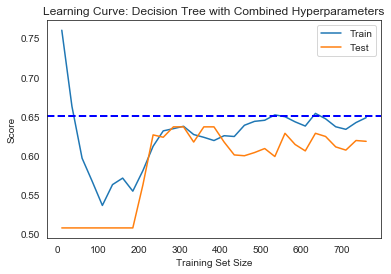

In [114]:
#### LEARNING CURVE
fig2 = plt.figure()
plt.plot(sizes, train_mean, label='Train')
plt.plot(sizes, test_mean, label='Test')
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.title('Learning Curve: Decision Tree with Combined Hyperparameters')
plt.axhline(0.65,linewidth=2,linestyle="--",color='b')
plt.legend()
plt.show()
#fig2.savefig('learning_curve.png')

#### (b) Logistic LASSO Regresion

In [115]:
# Fit model
lr1 = LogisticRegression(max_iter=1000,random_state=1)
lr1.fit(Xtrain,Ytrain)
lr1_acc=lr1.score(Xtest, Ytest)
lr1_acc

0.6224489795918368

In [116]:
lr1_cm = confusion_matrix(lr1.predict(Xtest),Ytest)
lr1_cm 

array([[104,  64],
       [ 47,  79]], dtype=int64)

In [117]:
# calculate feature importance
lr1_coef = pd.DataFrame({'Feature': X.columns,
              'Coefficient': lr1.coef_[0],
              'Coefficient (Abs Val)': abs(lr1.coef_[0])})
lr1_coef

,Feature,Coefficient,Coefficient (Abs Val)
0,female,-0.585650,0.585650
1,age,-0.011018,0.011018
2,income_quintile,0.284689,0.284689
3,in_workforce,-0.169600,0.169600
4,debit_card,0.446097,0.446097
5,credit_card,-0.512201,0.512201
6,saved_business_12mos,0.334721,0.334721
7,saved_retirement_12mos,0.508636,0.508636
8,loan_fin_realestate,0.444145,0.444145
9,borrowed_medical_12mos,-0.028211,0.028211


In [118]:
sizes = np.arange(10, 780, 25)
train_sizes, train_scores, test_scores = learning_curve(lr1, 
                                                        X, Y, cv=5, train_sizes=sizes)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

C:\DataScience\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

  FitFailedWarning)


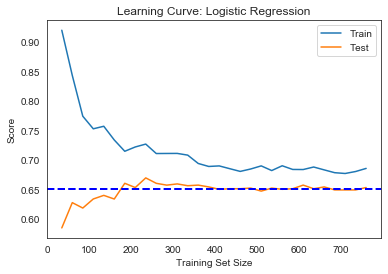

In [119]:
#### LEARNING CURVE
fig2 = plt.figure()
plt.plot(sizes, train_mean, label='Train')
plt.plot(sizes, test_mean, label='Test')
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.title('Learning Curve: Logistic Regression')
plt.axhline(0.65,linewidth=2,linestyle="--",color='b')
plt.legend()
plt.show()
#fig2.savefig('learning_curve.png')

##### Create Pipeline

In [120]:
# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

lr_pipe = Pipeline([('pre_process', StandardScaler()),
                 ('model',LogisticRegression(penalty='l1',
                                             solver='liblinear',
                                             random_state=1))])

# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set
# https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

In [121]:
lr_pipe

Pipeline(memory=None,
         steps=[('pre_process',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l1', random_state=1,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [122]:
lr_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'pre_process', 'model', 'pre_process__copy', 'pre_process__with_mean', 'pre_process__with_std', 'model__C', 'model__class_weight', 'model__dual', 'model__fit_intercept', 'model__intercept_scaling', 'model__l1_ratio', 'model__max_iter', 'model__multi_class', 'model__n_jobs', 'model__penalty', 'model__random_state', 'model__solver', 'model__tol', 'model__verbose', 'model__warm_start'])

In [123]:
C_range = np.arange(0.1,10,.1)
train_scores, test_scores = validation_curve(lr_pipe,
                                             X, Y,
                                             param_name='model__C',
                                             param_range=C_range,
                                             cv=5)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

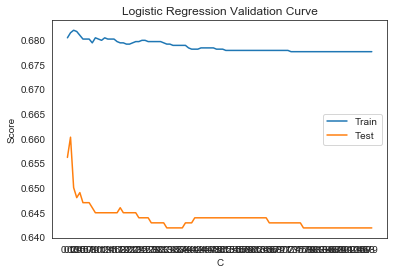

In [124]:
fig1 = plt.figure()
plt.plot(C_range, train_mean, label='Train')
plt.plot(C_range, test_mean, label='Test')
plt.xticks(C_range)
plt.xlabel('C')
plt.ylabel('Score')
plt.title('Logistic Regression Validation Curve')
plt.legend()
plt.show()

In [125]:
pd.DataFrame({'C_range':C_range,
              'train_mean':train_mean.round(4),
              'test_mean':test_mean.round(4),
             'difference':(train_mean-test_mean).round(4)}).sort_values(by="difference",ascending=True).head(10)

,C_range,train_mean,test_mean,difference
1,0.2,0.6814,0.6602,0.0212
0,0.1,0.6804,0.6561,0.0243
2,0.3,0.6819,0.6500,0.0319
4,0.5,0.6809,0.6490,0.0319
5,0.6,0.6801,0.6469,0.0332
6,0.7,0.6801,0.6469,0.0332
7,0.8,0.6801,0.6469,0.0332
8,0.9,0.6794,0.6459,0.0335
17,1.8,0.6794,0.6459,0.0335
3,0.4,0.6817,0.6480,0.0337


In [126]:
pd.DataFrame({'C':C_range,
              'train_mean':train_mean.round(4),
              'test_mean':test_mean.round(4),
             'difference':(train_mean-test_mean).round(4)}).sort_values(by="test_mean",ascending=False).head(10)

,C,train_mean,test_mean,difference
1,0.2,0.6814,0.6602,0.0212
0,0.1,0.6804,0.6561,0.0243
2,0.3,0.6819,0.6500,0.0319
4,0.5,0.6809,0.6490,0.0319
3,0.4,0.6817,0.6480,0.0337
5,0.6,0.6801,0.6469,0.0332
6,0.7,0.6801,0.6469,0.0332
7,0.8,0.6801,0.6469,0.0332
8,0.9,0.6794,0.6459,0.0335
17,1.8,0.6794,0.6459,0.0335


In [127]:
# Set C
C_value = 0.2
lr_pipe = Pipeline([('pre_process', StandardScaler()),
                 ('model',LogisticRegression(C=C_value,
                                             penalty='l1',
                                             solver='liblinear',
                                             random_state=1))])

In [128]:
# Fit model
lr_pipe.fit(Xtrain,Ytrain)
lr_pipe_acc=lr_pipe.score(Xtest, Ytest)
lr_pipe_acc

0.6224489795918368

In [129]:
# calculate coefficients
lr_pipe_coef = pd.DataFrame({'Feature': X.columns,
              'Coefficient': lr_pipe.named_steps['model'].coef_[0],
              'Coefficient (Abs Val)': abs(lr_pipe.named_steps['model'].coef_[0])})

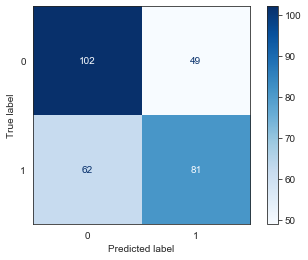

In [130]:
## Confusion Matrix
plot_confusion_matrix(lr_pipe, Xtest, Ytest,
                      values_format=',d',
                     cmap = plt.cm.Blues)

False positives (at 49) are less prevalent than false negatives (at 62).

In [131]:
lr_pipe_cm = confusion_matrix(lr_pipe.predict(Xtest),Ytest)
lr_pipe_cm

array([[102,  62],
       [ 49,  81]], dtype=int64)

In [132]:
sizes = np.arange(10, 780, 25)
train_sizes, train_scores, test_scores = learning_curve(lr_pipe, 
                                                        X, Y, cv=5, train_sizes=sizes)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

C:\DataScience\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

  FitFailedWarning)


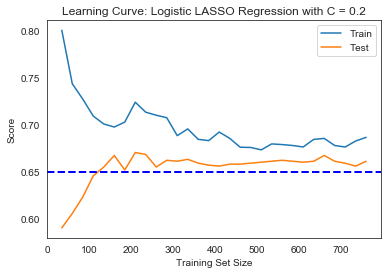

In [133]:
#### LEARNING CURVE
fig2 = plt.figure()
plt.plot(sizes, train_mean, label='Train')
plt.plot(sizes, test_mean, label='Test')
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.title('Learning Curve: Logistic LASSO Regression with C = 0.2')
plt.axhline(0.65,linewidth=2,linestyle="--",color='b')
plt.legend()
plt.show()
#fig2.savefig('learning_curve.png')

#### (c) Benchmarking

In [134]:
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=1)

In [135]:
pipe = Pipeline(steps=[('pre_process', MinMaxScaler()),('model',None)])

In [136]:
search_space = [
    
    # NaiveBayes
    {'model': [GaussianNB()]},
    
    # Logistic Regression
    {'model': [LogisticRegression()]},
    
    # LDA
    {'model': [LinearDiscriminantAnalysis()]},
       
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':np.arange(5,105,10)},
    
    # Neural Networks
    {'model': [MLPClassifier()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
    'model__max_depth':np.arange(2,10),
    'model__n_estimators':[100,500,1000,1500]},
         
    # SVC
    {'model' : [SVC()],
    'model__C':np.arange(0.1,1.1,0.1)}
    
]

In [137]:
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='accuracy',
                      n_jobs=-1)

In [138]:
search.fit(Xtrain,Ytrain)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pre_process',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('model', None)],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'model': [GaussianNB(priors=None,
                                               var_smoothing=1e-09)]},
                         {'model': [LogisticRegression(C=1.0, class_weight=...
                         {'model': [SVC(C=1.0, break_ties=False, cache_size=200,
                                        class_weight=None, coef0=0.0,
                                        decision_function_shape='ovr', degree=3,
                                        gamma='scale', kernel='rbf',
      

In [139]:
search.best_score_

0.6735186775440104

In [140]:
search.best_params_

{'model': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=3, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=1500,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False),
 'model__max_depth': 3,
 'model__n_estimators': 1500}

Note: The GridSearch may produce different optimal classifiers because a random seed was not set.

##### Benchmark: Random Forest

In [141]:
# Set hyperparameters
max_depth = 3
n_estimators = 1000
rf = RF(max_depth=max_depth,
        n_estimators=n_estimators,
        random_state=1)

In [142]:
# Fit model
rf.fit(Xtrain,Ytrain)
rf_acc = rf.score(Xtest, Ytest)
rf_acc

0.6258503401360545

In [143]:
# calculate node importance
rf_impt = pd.DataFrame({'Feature': Xtest.columns,
              'Importance': rf.feature_importances_})

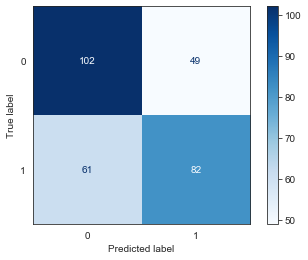

In [144]:
## Confusion Matrix
plot_confusion_matrix(rf, Xtest, Ytest,
                      values_format=',d',
                     cmap = plt.cm.Blues)

False positives (at 49) are less prevalent than false negatives (at 61).

In [145]:
rf_cm = confusion_matrix(rf.predict(Xtest),Ytest)
rf_cm 

array([[102,  61],
       [ 49,  82]], dtype=int64)

#### Evaluation

##### (a) Accuracy Scores

In [146]:
classifiers=["Decision Tree","Decision Tree","Decision Tree","Decision Tree",
            "Logistic Regression","Logistic Regression",
            "Random Forest"]
hyperparameters=['Maximum Tree Depth = 3',
            'Minimum Samples per Leaf = 93',
            'Cost Complexity Pruning Alpha = 0.005',
            'Combination of 3 previous values',
            'none',
            'LASSO (L1 penalty) with C = 0.2',
            'Maximum Tree Depth = 3,Estimators = 1,000']
acc_values = [tree1_acc,tree2_acc,tree3_acc,tree4_acc,lr1_acc,lr_pipe_acc,rf_acc]
acc_values = pd.Series(acc_values)*100

acc_table = pd.DataFrame({'Classifier':classifiers,
                          'Hyper-parameter': hyperparameters,
                          'Accuracy Score (in %)': acc_values})
acc_table.round(1)

,Classifier,Hyper-parameter,Accuracy Score (in %)
0,Decision Tree,Maximum Tree Depth = 3,64.6
1,Decision Tree,Minimum Samples per Leaf = 93,62.2
2,Decision Tree,Cost Complexity Pruning Alpha = 0.005,64.3
3,Decision Tree,Combination of 3 previous values,62.2
4,Logistic Regression,none,62.2
5,Logistic Regression,LASSO (L1 penalty) with C = 0.2,62.2
6,Random Forest,"Maximum Tree Depth = 3,Estimators = 1,000",62.6


##### (b) ROC Curve

In [147]:
# extract information to plot ROC curves for multiple models
def get_curve_data(ytrue, yprobs, pos_class_label):
    '''Computes data needed to plot an ROC or precision-recall curve
       Accepts arrays of true values, predicted probabilities, and class label
       Returns a dictionary of arrays for precision, recall, FPR, and TPR scores'''
    precision, recall, thresholds = precision_recall_curve(ytrue, yprobs, pos_label=pos_class_label)
    FPR, TPR, thresholds = roc_curve(ytrue, yprobs, pos_label=pos_class_label)
    rates = pd.DataFrame(dict(fpr=FPR, tpr=TPR))
    return {'precision': precision, 'recall': recall, 'rates': rates}

In [148]:
probabilities = {'Decision Tree with Max Tree Depth = 3': tree1.fit(Xtrain, Ytrain).predict_proba(Xtest),
                 'Decision Tree with Min Samples per Leaf = 93': tree2.fit(Xtrain, Ytrain).predict_proba(Xtest),
                 'Decision Tree with CCP Alpha = 0.005': tree3.fit(Xtrain, Ytrain).predict_proba(Xtest),
                 'Decision Tree with Combined Hyperparameters': tree4.fit(Xtrain, Ytrain).predict_proba(Xtest),
                 'Logistic Regression': lr1.fit(Xtrain, Ytrain).predict_proba(Xtest),
                 'Logistic LASSO Regression': lr_pipe.fit(Xtrain, Ytrain).predict_proba(Xtest),
                 'Random Forest': rf.fit(Xtrain, Ytrain).predict_proba(Xtest)}
tree1_data = get_curve_data(Ytest, probabilities['Decision Tree with Max Tree Depth = 3'][:,1], 1)
tree2_data = get_curve_data(Ytest, probabilities['Decision Tree with Min Samples per Leaf = 93'][:,1], 1)
tree3_data = get_curve_data(Ytest, probabilities['Decision Tree with CCP Alpha = 0.005'][:,1], 1)
tree4_data = get_curve_data(Ytest, probabilities['Decision Tree with Combined Hyperparameters'][:,1], 1)
lr1_data = get_curve_data(Ytest, probabilities['Logistic Regression'][:,1], 1)
lr_pipe_data = get_curve_data(Ytest, probabilities['Logistic LASSO Regression'][:,1], 1)
rf_data = get_curve_data(Ytest, probabilities['Random Forest'][:,1], 1)

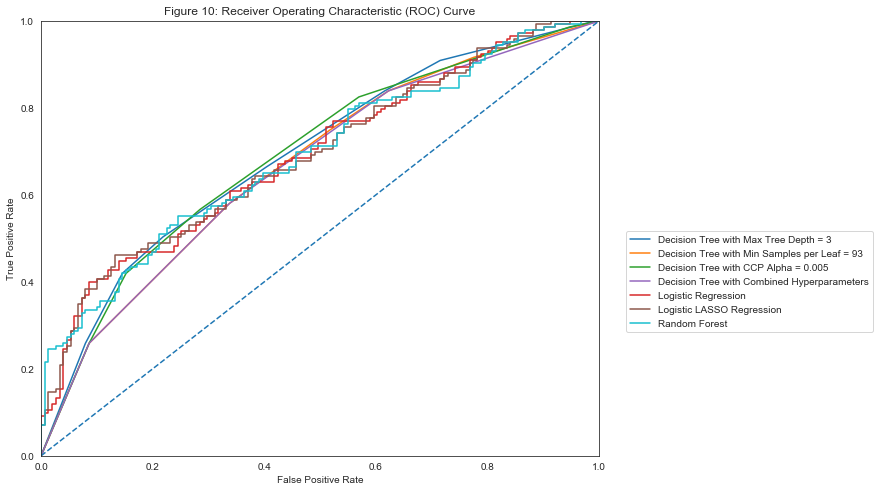

In [149]:
plt.figure(figsize=(10,8))
plt.plot(tree1_data['rates'].fpr, tree1_data['rates'].tpr, 'tab:blue', label='Decision Tree with Max Tree Depth = 3')
plt.plot(tree2_data['rates'].fpr, tree2_data['rates'].tpr, 'tab:orange', label='Decision Tree with Min Samples per Leaf = 93')
plt.plot(tree3_data['rates'].fpr, tree3_data['rates'].tpr, 'tab:green', label='Decision Tree with CCP Alpha = 0.005')
plt.plot(tree4_data['rates'].fpr, tree4_data['rates'].tpr, 'tab:purple', label='Decision Tree with Combined Hyperparameters')
plt.plot(lr1_data['rates'].fpr, lr1_data['rates'].tpr, 'tab:red', label='Logistic Regression')
plt.plot(lr_pipe_data['rates'].fpr, lr_pipe_data['rates'].tpr, 'tab:brown', label='Logistic LASSO Regression')
plt.plot(rf_data['rates'].fpr, rf_data['rates'].tpr, 'tab:cyan', label='Random Forest')
plt.plot([0, 1], [0, 1],'--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Figure 10: Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="center right",bbox_to_anchor=(1.5, 0.4))
plt.savefig('Fig10.png',bbox_inches="tight")

##### (c) Confusion Matrix

In [150]:
cf_models=['Decision Tree with Max Tree Depth = 3',
            'Decision Tree with Min Samples per Leaf = 93',
            'Decision Tree with CCP Alpha = 0.005',
            'Decision Tree with Combined Hyperparameters',
            'Logistic Regression',
            'Logistic LASSO Regression',
            'Random Forest']
cf_predictions = ['True Negative',
                 'False Negative',
                 'False Positive',
                 'True Positive']
cm_df = pd.DataFrame(index=cf_models,columns=cf_predictions)

In [151]:
cf_matrices = [tree1_cm,tree2_cm,tree3_cm,tree4_cm,
              lr1_cm,lr_pipe_cm,rf_cm]

row_count=-1
col_count=0
for i in cf_matrices:
    row_count += 1
    col_count=0
    for row in i:
        for col in row:
            cm_df.iloc[row_count,col_count]=col
            col_count += 1
    
cm_df

,True Negative,False Negative,False Positive,True Positive
Decision Tree with Max Tree Depth = 3,118,71,33,72
Decision Tree with Min Samples per Leaf = 93,100,60,51,83
Decision Tree with CCP Alpha = 0.005,108,62,43,81
Decision Tree with Combined Hyperparameters,100,60,51,83
Logistic Regression,104,64,47,79
Logistic LASSO Regression,102,62,49,81
Random Forest,102,61,49,82


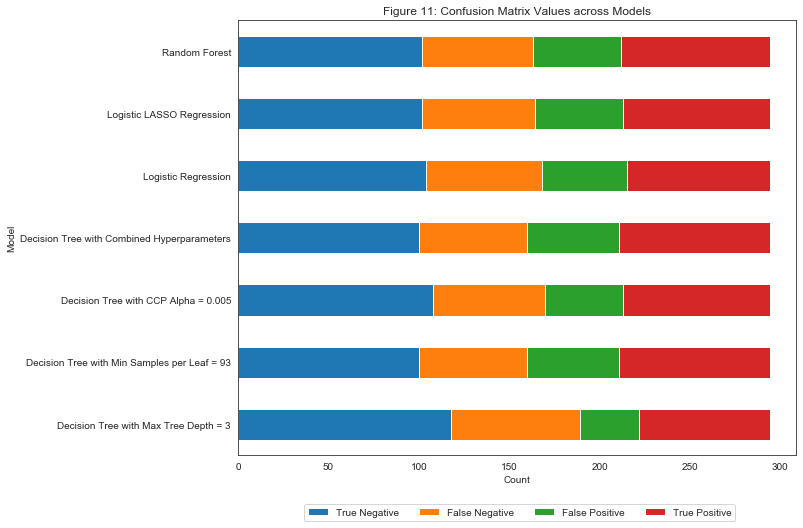

In [152]:
cm_df.plot.barh(stacked=True,figsize=(10,8))
plt.xlabel('Count')
plt.ylabel('Model')
plt.title('Figure 11: Confusion Matrix Values across Models')
plt.legend(bbox_to_anchor=(.9, -.1), ncol=4)
plt.xticks(rotation=0)
plt.savefig('Fig11.png',bbox_inches="tight")

The highest number of true negatives and lowest number of false positives occur at the 1st Decision Tree Model (max tree depth of 3), but this comes at the cost of high False Negatives. So if there are interventions, recipients will be larger than needed.

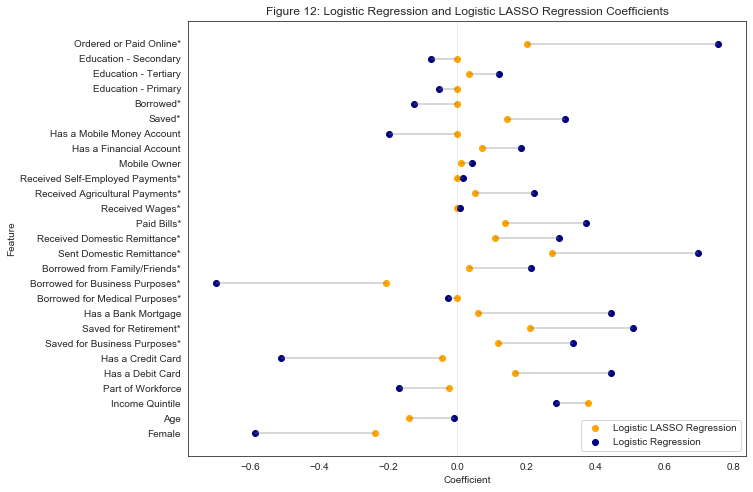

In [153]:
plt.figure(figsize=(10,8))
plt.axvline(0,linewidth=.5,color='gray',alpha=.3)
plt.scatter(x=lr_pipe_coef["Coefficient"],
            y=lr1_coef["Feature"],
           color='orange',
           label='Logistic LASSO Regression')
plt.hlines(y=lr1_coef["Feature"],
          xmin=lr1_coef["Coefficient"],
          xmax=lr_pipe_coef["Coefficient"],
           color='grey',
          alpha=0.4)
plt.scatter(x=lr1_coef["Coefficient"],
            y=lr1_coef["Feature"],
           color='navy',
           label='Logistic Regression')
yticklabels=['Female','Age','Income Quintile','Part of Workforce','Has a Debit Card','Has a Credit Card','Saved for Business Purposes*','Saved for Retirement*','Has a Bank Mortgage','Borrowed for Medical Purposes*','Borrowed for Business Purposes*','Borrowed from Family/Friends*','Sent Domestic Remittance*','Received Domestic Remittance*','Paid Bills*','Received Wages*','Received Agricultural Payments*','Received Self-Employed Payments*','Mobile Owner','Has a Financial Account','Has a Mobile Money Account','Saved*','Borrowed*','Education - Primary','Education - Tertiary','Education - Secondary','Ordered or Paid Online*']
plt.yticks(lr1_coef["Feature"],yticklabels)
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Figure 12: Logistic Regression and Logistic LASSO Regression Coefficients')
plt.legend(loc="lower right")
plt.savefig('Fig12.png',bbox_inches="tight")

In [154]:
lr1_coef.sort_values("Coefficient (Abs Val)", ascending=False)

,Feature,Coefficient,Coefficient (Abs Val)
26,online_txn,0.754566,0.754566
10,borrowed_business_12mos,-0.698760,0.698760
12,remit_dom_sent_12mos,0.698117,0.698117
0,female,-0.585650,0.585650
5,credit_card,-0.512201,0.512201
7,saved_retirement_12mos,0.508636,0.508636
4,debit_card,0.446097,0.446097
8,loan_fin_realestate,0.444145,0.444145
14,paid_bills_12mos,0.372665,0.372665
6,saved_business_12mos,0.334721,0.334721


In [155]:
lr_pipe_coef.sort_values("Coefficient (Abs Val)", ascending=False)

,Feature,Coefficient,Coefficient (Abs Val)
2,income_quintile,0.379163,0.379163
12,remit_dom_sent_12mos,0.273700,0.273700
0,female,-0.238183,0.238183
7,saved_retirement_12mos,0.211520,0.211520
10,borrowed_business_12mos,-0.207642,0.207642
26,online_txn,0.202314,0.202314
4,debit_card,0.166893,0.166893
21,saved_12mos,0.144553,0.144553
14,paid_bills_12mos,0.139567,0.139567
1,age,-0.138643,0.138643


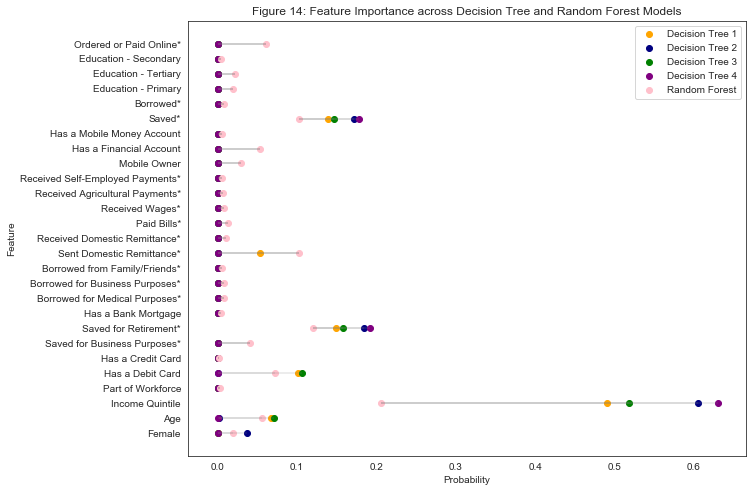

In [156]:
plt.figure(figsize=(10,8))
#plt.axvline(0,linewidth=.5,color='gray',alpha=.3)
plt.scatter(x=tree1_impt["Importance"],
            y=tree1_impt["Feature"],
           color='orange',
           label='Decision Tree 1')
plt.scatter(x=tree2_impt["Importance"],
            y=tree2_impt["Feature"],
           color='navy',
           label='Decision Tree 2')
plt.scatter(x=tree3_impt["Importance"],
            y=tree3_impt["Feature"],
           color='green',
           label='Decision Tree 3')
plt.scatter(x=tree4_impt["Importance"],
            y=tree4_impt["Feature"],
           color='purple',
           label='Decision Tree 4')
plt.scatter(x=rf_impt["Importance"],
            y=rf_impt["Feature"],
           color='pink',
           label='Random Forest')
plt.hlines(y=rf_impt["Feature"],
          xmin=rf_impt["Importance"],
          xmax=tree4_impt["Importance"],
           color='grey',
          alpha=0.2)
plt.hlines(y=rf_impt["Feature"],
          xmin=rf_impt["Importance"],
          xmax=tree3_impt["Importance"],
           color='grey',
          alpha=0.2)
plt.hlines(y=rf_impt["Feature"],
          xmin=rf_impt["Importance"],
          xmax=tree2_impt["Importance"],
           color='grey',
          alpha=0.2)
plt.yticks(lr1_coef["Feature"],yticklabels)
plt.xlabel('Probability')
plt.ylabel('Feature')
plt.title('Figure 14: Feature Importance across Decision Tree and Random Forest Models')
plt.legend(loc="upper right")
plt.savefig('Fig14.png',bbox_inches="tight")